In [1]:
import glob
import pandas as pd
import pybedtools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ct = 'DG_Glut'

In [3]:
ddir = f'/data/female-amb/Diff.Result/CellType.Age.Diff.Domain/{ct}'
_dir = '/home/qzeng_salk_edu/project/'
binall = pd.read_csv(f'{_dir}/binall.csv',  index_col =0)
binall.columns = ['chrom', 'start','end']

In [4]:
all_diff_domain = pd.read_csv('ALL.Diff.Domain.csv', index_col = 0)
ct_diff_domain = all_diff_domain[all_diff_domain['celltype'] == ct]
ct_diff_domain =  ct_diff_domain[(ct_diff_domain['18mo-8wk'] > 0.05)]  #& (ct_diff_domain['8wk'] < 0.2)
ct_diff_domain = pd.concat([ct_diff_domain, binall], axis = 1).dropna()
ct_diff_domain = ct_diff_domain[[ 'chrom', 'start', 'end','8wk', '9mo', '18mo', '18mo-8wk', 'celltype']]
ct_diff_domain.head()

,chrom,start,end,8wk,9mo,18mo,18mo-8wk,celltype
chr1_381,chr1,9525000,9550000,0.111111,0.125786,0.162823,0.051712,DG_Glut
chr1_686,chr1,17150000,17175000,0.153739,0.165618,0.241090,0.087352,DG_Glut
chr1_1020,chr1,25500000,25525000,0.092942,0.098532,0.144654,0.051712,DG_Glut
chr1_1034,chr1,25850000,25875000,0.120196,0.122292,0.197065,0.076869,DG_Glut
chr1_1346,chr1,33650000,33675000,0.145353,0.139064,0.201957,0.056604,DG_Glut


In [5]:
print(f"{ct_diff_domain.shape[0]} diff domain boundary")

494 diff domain boundary


## genes thst acrossed the diff boundary?

In [6]:
genes = pd.read_csv('mm10.gene.bed', sep = '\t', header = None)
genes.columns = ['gene_chr','gene_start','gene_end','gene_name','strand','gene_type', 'gene_length']
genes.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length
0,chr1,3073253,3074322,4933401J01Rik,+,TEC,1069
1,chr1,3102016,3102125,Gm26206,+,snRNA,109
2,chr1,3205901,3671498,Xkr4,-,protein_coding,465597
3,chr1,3252757,3253236,Gm18956,+,processed_pseudogene,479
4,chr1,3365731,3368549,Gm37180,-,TEC,2818


In [7]:
genes_bed = pybedtools.BedTool.from_dataframe(genes)
ct_diff_domain_bed = pybedtools.BedTool.from_dataframe(ct_diff_domain)
# Find overlaps
overlaps = genes_bed.intersect(ct_diff_domain_bed, wa=True, wb=True)
overlaps_df = overlaps.to_dataframe(names = genes.columns.tolist() + ct_diff_domain.columns.tolist())
overlaps_df.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length,chrom,start,end,8wk,9mo,18mo,18mo-8wk,celltype
0,chr1,9545408,9547455,Rrs1,+,protein_coding,2047,chr1,9525000,9550000,0.111111,0.125786,0.162823,0.051712,DG_Glut
1,chr1,9547948,9580673,Adhfe1,+,protein_coding,32725,chr1,9525000,9550000,0.111111,0.125786,0.162823,0.051712,DG_Glut
2,chr1,17145362,17164271,Gdap1,+,protein_coding,18909,chr1,17150000,17175000,0.153739,0.165618,0.241090,0.087352,DG_Glut
3,chr1,17168403,17173103,Gm28784,+,lncRNA,4700,chr1,17150000,17175000,0.153739,0.165618,0.241090,0.087352,DG_Glut
4,chr1,25067476,25829707,Adgrb3,-,protein_coding,762231,chr1,25500000,25525000,0.092942,0.098532,0.144654,0.051712,DG_Glut


In [8]:
print(f"{overlaps_df.shape[0]} genes overlap with the boundary")

656 genes overlap with the boundary


In [9]:
deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
use_genes = expr[expr.sum(axis = 1) > 0.05].index

stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

In [10]:
all_gene_result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
all_gene_result['log2(18mo/2mo)'] = np.log2(all_gene_result['fc']) 
all_gene_result['-log10(padj)'] = -np.log10(all_gene_result['fdr'] + sys.float_info.min)
all_gene_result =all_gene_result[all_gene_result['fdr'] != 1]
deg_result = all_gene_result[(all_gene_result['fdr'] < 0.01) & (abs(all_gene_result['log2(18mo/2mo)']) > 0.2)]

In [11]:
overlap_deg_result = deg_result.loc[deg_result.index.isin(overlaps_df['gene_name'].values)]
overlap_deg_result['gene_length'] = overlap_deg_result.index.map(overlaps_df.set_index('gene_name')['gene_length'].to_dict())
overlap_deg_result['abs_log2(18mo/2mo)'] = abs(overlap_deg_result['log2(18mo/2mo)'])
overlap_deg_result.sort_values('fdr').head()

,fc,fdr,log2(18mo/2mo),-log10(padj),gene_length,abs_log2(18mo/2mo)
gene,,,,,,
Nrxn3,1.678759,0.000000e+00,0.747395,307.652656,1612059,0.747395
Grid1,0.758133,7.466603e-136,-0.399477,135.126877,763271,0.399477
Pard3,0.749943,7.359785e-129,-0.415147,128.133135,548393,0.415147
Chst9,0.687510,2.744547e-94,-0.540548,93.561529,308233,0.540548
Pigk,0.530213,4.402500e-88,-0.915355,87.356301,266308,0.915355


In [12]:
print(f"{overlap_deg_result.shape[0]} genes overlap")

64 genes overlap


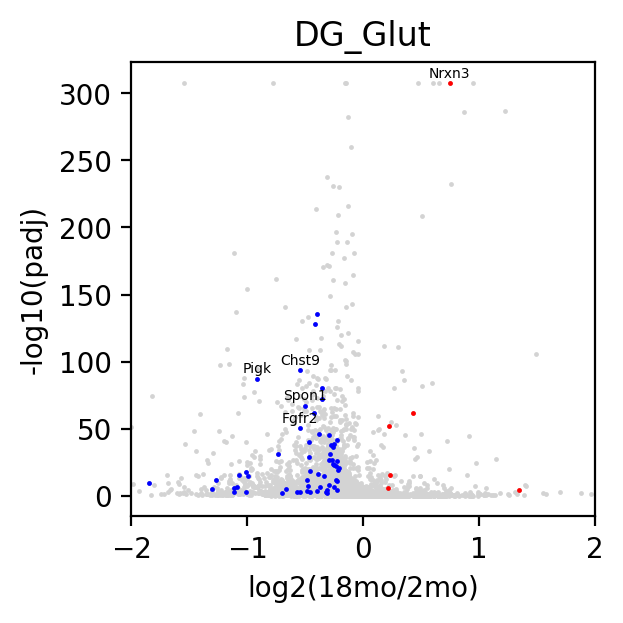

In [13]:
ncols = 1
nrows = 1

fig, ax = plt.subplots(figsize = (ncols*3,nrows*3), 
                         ncols = ncols, nrows = nrows, 
                         dpi = 200, constrained_layout = True)

sns.scatterplot(data = all_gene_result,
                    linewidth = 0,
                    ax = ax,
                    color = 'lightgrey',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

sns.scatterplot(data = overlap_deg_result[overlap_deg_result['log2(18mo/2mo)'] < 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'blue',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

sns.scatterplot(data = overlap_deg_result[overlap_deg_result['log2(18mo/2mo)'] > 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'red',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')
ax.set_title(ct)
ax.set(xlim = (-2,2)) #, ylim = (0, 100)

top_genes = overlap_deg_result[(overlap_deg_result['abs_log2(18mo/2mo)'] > 0.5)]
top_genes = top_genes.sort_values('fdr').head(5)
for _, row in top_genes.iterrows():
    ax.annotate(row.name, (row['log2(18mo/2mo)'], row['-log10(padj)']), 
                textcoords="offset points", xytext=(0,2), ha='center', fontsize = 5)


In [14]:
overlaps_df.to_csv('All.BoundaryGene.csv')
overlap_deg_result.to_csv('DiffExpress.BoundaryGene.csv')